### **1. Setup and load data**

##### **1.1 Install dependencies and data**

In [1]:
import tensorflow as tf
import os #used for handling file operations

In [2]:
tf.config.list_physical_devices('GPU') #verify tensorflow is using the gpu

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Avoid OOM errors. Setting GPU memory growth limit #### if this approach still doesn't resolve the memory consumption issue. we need to reduce size of the mini batches when training
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

#### **1.2 Load Data**

In [4]:
# # # Change working directory to notebook location# 
# notebook_path = r"E:\AKILA\RiceClassifcation"# 
# os.chdir(notebook_path# )
# print(f"Current working directory: {os.getcwd()}")

In [5]:
# import cv2i

# data_dir = "Data"
# data_dir_pat h = s.path.join(cwd, data_dirf)
# o.litdi()r(data_di:r)

In [6]:
DATA_DIR = "Data2"
BATCH_SIZE = 8
IMAGE_SIZE = (260, 260)
ROOT_PATTERN = f"{DATA_DIR}/*/*/*.JPG"

In [7]:
# create dataset of file paths
paths = tf.data.Dataset.list_files(file_pattern=ROOT_PATTERN,shuffle=True)

In [8]:
# create label vocabularies


type_dirs = tf.io.gfile.listdir(DATA_DIR)
# filter, to only keep dir names
image_class_type_dirs = []  # will contain ['AT 362', 'BG 357', 'BG 360', 'BW 367',......]
for dir in type_dirs:
    if tf.io.gfile.isdir(os.path.join(DATA_DIR,dir)):
        image_class_type_dirs.append(dir)


# quality_dirs = tf.io.gfile.listdir(os.path.join(DATA_DIR,image_class_type_dirs[0]))
# filter, to only keep dir names
# image_class_quality_dirs = [] # will contain ['Bad', 'Good']
# for dir in quality_dirs:
#     if tf.io.gfile.isdir(os.path.join(DATA_DIR,image_class_type_dirs[0],dir)):
#         image_class_quality_dirs.append(dir)
image_class_quality_dirs = ['Bad', 'Good']

image_class_type_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(image_class_type_dirs),
        values=tf.constant(list(range(len(image_class_type_dirs))))
        ),
    default_value=-1
)

image_class_quality_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(image_class_quality_dirs),
        values=tf.constant(list(range(len(image_class_quality_dirs))))
    ),
    default_value=-1
)

In [9]:
# helper function to extract type and quality label 
@tf.function
def parse_label(path):
    # path format should be Data\Type\Quality\Image.JPG or Data/Type/Quality/Image.JPG
    # Normalize path: convert backslashes to forward slashes
    path = tf.strings.regex_replace(path, "\\\\", "/")
    
    # Split by forward slash
    parts = tf.strings.split(path, sep="/")
    
    # parts should be: ['Data', 'Type', 'Quality', 'Image.JPG']
    # Get the type and quality from the correct indices
    rice_type = parts[-3]
    rice_quality = parts[-2]

    t = image_class_type_table.lookup(rice_type)
    q = image_class_quality_table.lookup(rice_quality)
    return t, q

# helper function to load and preprocess image
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])  # Set shape before resize
    img = tf.image.resize(img, IMAGE_SIZE)
    img = img / 255.0
    return img

# act as the lambda function for the mapping
def load_item(path):
    t, q = parse_label(path)
    image = load_image(path)
    return image, {"type": t, "quality": q}

In [10]:
# Split data into training and validation sets (80/20 split)
DATASET_SIZE = len(list(paths))
TRAIN_SIZE = int(0.8 * DATASET_SIZE)
VAL_SIZE = DATASET_SIZE - TRAIN_SIZE

# Recreate paths for train/val split
paths_full = tf.data.Dataset.list_files(file_pattern=ROOT_PATTERN, shuffle=True)

# Split the dataset
train_paths = paths_full.take(TRAIN_SIZE)
val_paths = paths_full.skip(TRAIN_SIZE)

# Create training dataset
train_dataset = (
    train_paths
    .shuffle(100)
    .map(load_item, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Create validation dataset
val_dataset = (
    val_paths
    .shuffle(100)
    .map(load_item, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print(f"Total dataset size: {DATASET_SIZE}")
print(f"Training set size: {TRAIN_SIZE}")
print(f"Validation set size: {VAL_SIZE}")
print(f"Train/Val split: 80/20")

Total dataset size: 332
Training set size: 265
Validation set size: 67
Train/Val split: 80/20


### **2. Model Building**

In [11]:

# Enhanced data augmentation layer for better generalization
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

inputs = tf.keras.Input(shape=(260, 260, 3))

x = data_augmentation(inputs)  
x = tf.keras.applications.efficientnet.preprocess_input(x)

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(260,260,3)
)
base.trainable = False

x = base(x)

type_out = tf.keras.layers.Dense(len(image_class_type_dirs), activation="softmax", name="type")(x)
quality_out = tf.keras.layers.Dense(2, activation="softmax", name="quality")(x)

model = tf.keras.Model(inputs, {"type": type_out, "quality": quality_out})

### **3. Compile**

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        "type": "sparse_categorical_crossentropy",
        "quality": "sparse_categorical_crossentropy",
    },
    metrics=["accuracy"]
)


### **4. Train**

In [16]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50)

Epoch 1/50
34/34 [==============================] - 6s 175ms/step - loss: 2.0484 - quality_loss: 0.7293 - type_loss: 1.3192 - quality_accuracy: 0.4943 - type_accuracy: 0.3396 - val_loss: 2.0179 - val_quality_loss: 0.7552 - val_type_loss: 1.2627 - val_quality_accuracy: 0.4030 - val_type_accuracy: 0.3433
Epoch 2/50
Epoch 2/50
34/34 [==============================] - 6s 173ms/step - loss: 2.0383 - quality_loss: 0.7047 - type_loss: 1.3336 - quality_accuracy: 0.5132 - type_accuracy: 0.3396 - val_loss: 2.0226 - val_quality_loss: 0.6993 - val_type_loss: 1.3234 - val_quality_accuracy: 0.5522 - val_type_accuracy: 0.3582
Epoch 3/50
Epoch 3/50
34/34 [==============================] - 7s 208ms/step - loss: 2.0583 - quality_loss: 0.7139 - type_loss: 1.3444 - quality_accuracy: 0.5208 - type_accuracy: 0.3245 - val_loss: 1.9540 - val_quality_loss: 0.6968 - val_type_loss: 1.2572 - val_quality_accuracy: 0.4328 - val_type_accuracy: 0.3433
Epoch 4/50
Epoch 4/50
34/34 [==============================] - 8s 

In [14]:
### **5. Training Analysis and Visualization**

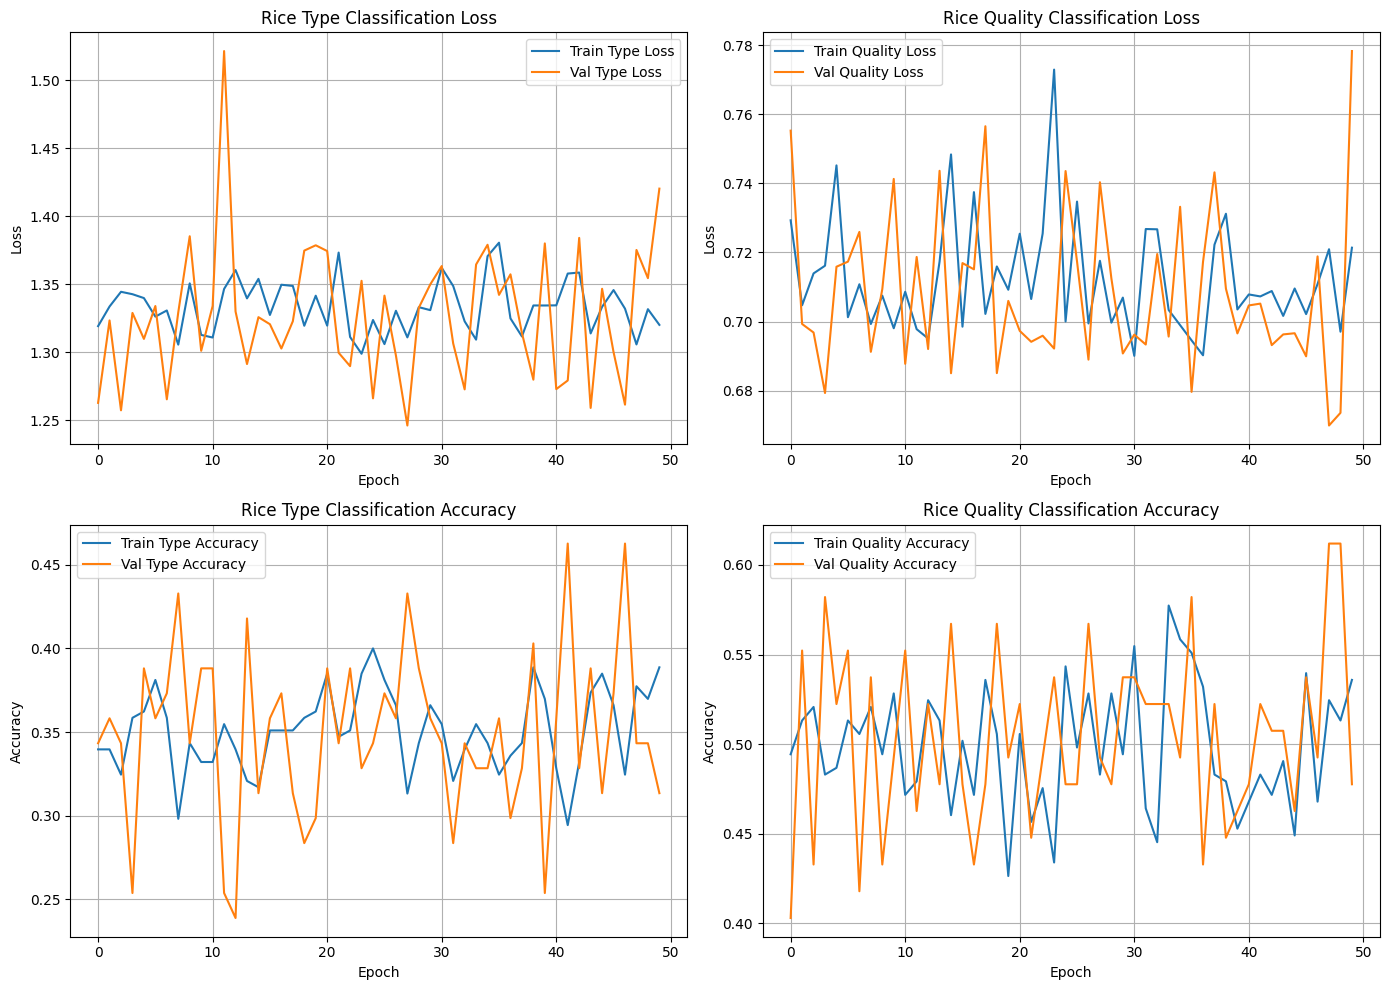


TRAINING ANALYSIS SUMMARY

Final Training Metrics:
  Type Loss: 1.3201
  Type Accuracy: 0.3887
  Quality Loss: 0.7214
  Quality Accuracy: 0.5358

Final Validation Metrics:
  Type Loss: 1.4203
  Type Accuracy: 0.3134
  Quality Loss: 0.7783
  Quality Accuracy: 0.4776

Overfitting Analysis:
  Type Loss Difference (Val - Train): 0.1003
  Quality Loss Difference (Val - Train): 0.0569
  ⚠️  Possible overfitting detected


In [17]:
import matplotlib.pyplot as plt

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Type loss
axes[0, 0].plot(history.history['type_loss'], label='Train Type Loss')
axes[0, 0].plot(history.history['val_type_loss'], label='Val Type Loss')
axes[0, 0].set_title('Rice Type Classification Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Quality loss
axes[0, 1].plot(history.history['quality_loss'], label='Train Quality Loss')
axes[0, 1].plot(history.history['val_quality_loss'], label='Val Quality Loss')
axes[0, 1].set_title('Rice Quality Classification Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Type accuracy
axes[1, 0].plot(history.history['type_accuracy'], label='Train Type Accuracy')
axes[1, 0].plot(history.history['val_type_accuracy'], label='Val Type Accuracy')
axes[1, 0].set_title('Rice Type Classification Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Quality accuracy
axes[1, 1].plot(history.history['quality_accuracy'], label='Train Quality Accuracy')
axes[1, 1].plot(history.history['val_quality_accuracy'], label='Val Quality Accuracy')
axes[1, 1].set_title('Rice Quality Classification Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("TRAINING ANALYSIS SUMMARY")
print("="*60)
print(f"\nFinal Training Metrics:")
print(f"  Type Loss: {history.history['type_loss'][-1]:.4f}")
print(f"  Type Accuracy: {history.history['type_accuracy'][-1]:.4f}")
print(f"  Quality Loss: {history.history['quality_loss'][-1]:.4f}")
print(f"  Quality Accuracy: {history.history['quality_accuracy'][-1]:.4f}")

print(f"\nFinal Validation Metrics:")
print(f"  Type Loss: {history.history['val_type_loss'][-1]:.4f}")
print(f"  Type Accuracy: {history.history['val_type_accuracy'][-1]:.4f}")
print(f"  Quality Loss: {history.history['val_quality_loss'][-1]:.4f}")
print(f"  Quality Accuracy: {history.history['val_quality_accuracy'][-1]:.4f}")

print(f"\nOverfitting Analysis:")
type_loss_diff = history.history['val_type_loss'][-1] - history.history['type_loss'][-1]
quality_loss_diff = history.history['val_quality_loss'][-1] - history.history['quality_loss'][-1]
print(f"  Type Loss Difference (Val - Train): {type_loss_diff:.4f}")
print(f"  Quality Loss Difference (Val - Train): {quality_loss_diff:.4f}")

if type_loss_diff > 0.1 or quality_loss_diff > 0.1:
    print("  ⚠️  Possible overfitting detected")
else:
    print("  ✓ Good generalization")

print("="*60)

### **6. Testing with Confidence Metrics**

In [ ]:
import numpy as np

# Function to predict on a single image with confidence
def predict_image_with_confidence(image_path, confidence_threshold=0.5):
    """
    Predict rice type and quality with confidence scores
    
    Args:
        image_path: Path to the image
        confidence_threshold: Only show predictions above this threshold
    
    Returns:
        Dictionary with predictions and confidence scores
    """
    # Load and preprocess image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = img / 255.0
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    
    # Make prediction
    predictions = model.predict(img, verbose=0)
    
    # Get predictions for type and quality
    type_probs = predictions['type'][0]
    quality_probs = predictions['quality'][0]
    
    # Get top predictions
    type_pred_idx = np.argmax(type_probs)
    quality_pred_idx = np.argmax(quality_probs)
    
    type_confidence = float(type_probs[type_pred_idx])
    quality_confidence = float(quality_probs[quality_pred_idx])
    
    # Get class names
    type_name = image_class_type_dirs[type_pred_idx]
    quality_name = image_class_quality_dirs[quality_pred_idx]
    
    # Get top N alternatives
    type_top_indices = np.argsort(type_probs)[::-1][:3]
    quality_top_indices = np.argsort(quality_probs)[::-1][:2]
    
    result = {
        'image_path': image_path,
        'type_prediction': type_name,
        'type_confidence': type_confidence,
        'type_alternatives': [
            {
                'name': image_class_type_dirs[idx],
                'confidence': float(type_probs[idx])
            } for idx in type_top_indices
        ],
        'quality_prediction': quality_name,
        'quality_confidence': quality_confidence,
        'quality_alternatives': [
            {
                'name': image_class_quality_dirs[idx],
                'confidence': float(quality_probs[idx])
            } for idx in quality_top_indices
        ],
        'is_confident_type': type_confidence >= confidence_threshold,
        'is_confident_quality': quality_confidence >= confidence_threshold,
    }
    
    return result

# Function to display results nicely
def display_prediction_result(result):
    """Display prediction results with confidence scores"""
    print("\n" + "="*70)
    print(f"PREDICTION RESULT: {result['image_path']}")
    print("="*70)
    
    print(f"\n🌾 RICE TYPE CLASSIFICATION:")
    print(f"  Primary Prediction: {result['type_prediction']}")
    print(f"  Confidence: {result['type_confidence']:.2%}")
    print(f"  Status: {'✅ HIGH CONFIDENCE' if result['is_confident_type'] else '⚠️ LOW CONFIDENCE'}")
    
    print(f"\n  Alternative Options:")
    for i, alt in enumerate(result['type_alternatives'], 1):
        print(f"    {i}. {alt['name']}: {alt['confidence']:.2%}")
    
    print(f"\n🎯 RICE QUALITY CLASSIFICATION:")
    print(f"  Primary Prediction: {result['quality_prediction']}")
    print(f"  Confidence: {result['quality_confidence']:.2%}")
    print(f"  Status: {'✅ HIGH CONFIDENCE' if result['is_confident_quality'] else '⚠️ LOW CONFIDENCE'}")
    
    print(f"\n  Alternative Options:")
    for i, alt in enumerate(result['quality_alternatives'], 1):
        print(f"    {i}. {alt['name']}: {alt['confidence']:.2%}")
    
    print("\n" + "="*70)

# Test on a few validation samples
print("\nTesting on validation set samples...")
print("="*70)

# Get a few samples from validation dataset
test_count = 0
for img_batch, labels_batch in val_dataset.take(3):  # Take 3 batches
    for i in range(min(2, img_batch.shape[0])):  # 2 images per batch
        # Get the actual file path - we need to reconstruct it
        # For now, let's predict on the batch directly
        if test_count >= 5:
            break
        test_count += 1

# Better approach: Test on the first few validation paths
test_paths = list(val_paths.take(5).as_numpy_iterator())

if test_paths:
    for test_path in test_paths:
        try:
            test_path_str = test_path.decode('utf-8') if isinstance(test_path, bytes) else test_path
            result = predict_image_with_confidence(test_path_str, confidence_threshold=0.5)
            display_prediction_result(result)
        except Exception as e:
            print(f"Error processing {test_path}: {e}")
else:
    print("No validation paths available for testing")